# NBA Single Game Predictions - Modeling

##  Summary

This notebook will be dedicated to building the model that could calculate the probability of the home team winning next game

## Implementations

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

Read the team and players game log data

In [60]:
team_gamelogs = pd.read_csv('data/Team Gamelogs.csv')
team_standings = pd.read_csv('data/Team Standings.csv')
teams_mapping = pd.read_csv('data/teams.csv')
team_splits = pd.read_csv('data/Team Splits.csv')
players_game_logs = pd.read_csv('data/Player Stats.csv')
players_active_games = pd.read_csv('data/Player Active Games.csv')
player_injuries = pd.read_csv('data/Player Injuries.csv')
game_schedule = pd.read_csv('data/Schduled Games.csv')

### Home Court Advantage

It is reasonable to believe that teams tend to play better at home, here is the proof

In [3]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_context('notebook')

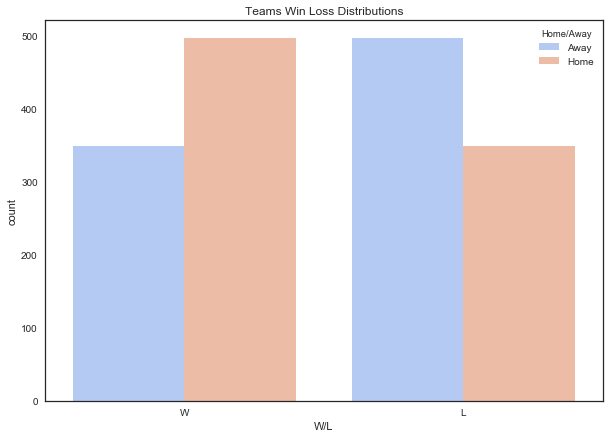

In [4]:
sns.set_style('white')
sns.countplot(x = "W/L", hue = 'Home/Away', 
              palette = 'coolwarm', data = team_gamelogs).set_title('Teams Win Loss Distributions')
plt.show()

Clearly, teams generally perform better at home

**Calculate team's winning percentage in home/away situations**

In [5]:
team_standings['Home Strength'] = team_standings['Home'].apply(lambda x: 100 *float(x.split("-")[0]) / (float(x.split("-")[0]) 
                                                                 + float(x.split("-")[1])))

team_standings['Away Strength'] = team_standings['Road'].apply(lambda x: 100 *float(x.split("-")[0]) / (float(x.split("-")[0]) 
                                                                 + float(x.split("-")[1])))

In [6]:
team_homecourts = team_standings[['Team', 'Home Strength', 'Away Strength']].set_index('Team')

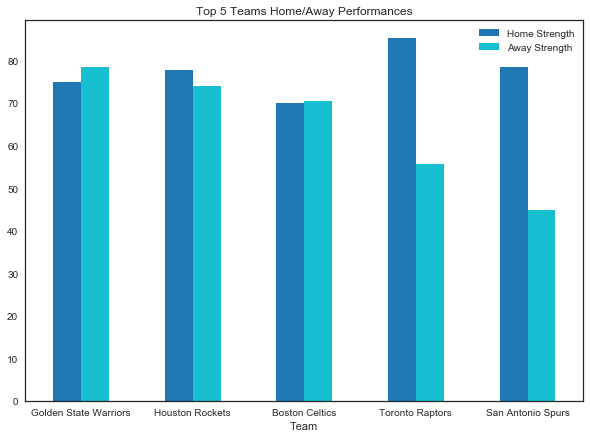

In [7]:
team_homecourts[0:5].plot.bar(colormap='tab10')
plt.xticks(rotation = 0)
plt.title('Top 5 Teams Home/Away Performances')
plt.show()

In [8]:
team_homecourts.reset_index(level = 0, inplace = True)

In [9]:
team_homecourts = team_homecourts.merge(teams_mapping, 
                                        left_on = 'Team', right_on = 'Franchise')[['Acronym', 'Home Strength', 'Away Strength']]

These wining percentages will serve as home/away strength score of a team. To no surprise, Golden State is the best team on this metric. Two of the top teams struggled on the road.

### Player Contribution Score

The game is won by the players, estimating the impacts of the players on a game is a natrual choice. This metric will be a measure of how strong the players contribute to the team's winning

** Player's Hot Streaks**

Basketball is a game of runs. Players' performance will not be constant over the course of an 82-game season. The players travel, go on hot streaks, drop into slumps - we will a player's performance will deviate from his season average stats. 

**Predicting Player's Performance Next Game**

I believe if a player is currently on a hot streak, it is reasonable to predict that this player will perform well in the next game. Using expotential weighted moving average model, we could smooth the data and provide an reasonble prediction of the player's next game performance. Using Russ as an example, find the EWMA of Russ' scoring for the past 5 games

In [10]:
Russ_games = players_active_games[players_active_games['Player'] == 'Russell Westbrook']

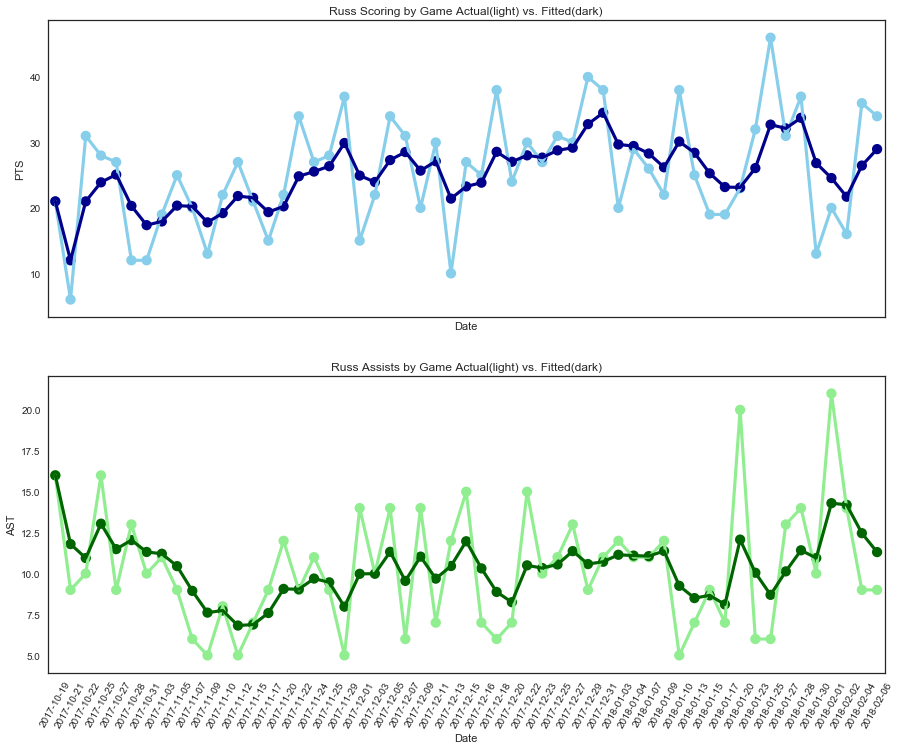

In [11]:
f, (plot1, plot2) = plt.subplots(2, sharex=True, figsize=(15,12))
sns.pointplot(x = 'Date', y = 'PTS', data = Russ_games,
              color='skyblue', label = 'Actual', ax = plot1)

sns.pointplot(x = Russ_games['Date'], 
              y = Russ_games.ewm(span = 5).mean()['PTS'],
              color='darkblue', label = 'Fitted', ax = plot1)

plot1.set_title('Russ Scoring by Game Actual(light) vs. Fitted(dark)' )


sns.pointplot(x = 'Date', y = 'AST', data = Russ_games, 
              color='lightgreen', label = 'Actual', ax = plot2)

sns.pointplot(x = Russ_games['Date'],
              y = Russ_games.ewm(span = 5).mean()['AST'], 
              color='darkgreen', label = 'Fitted', ax = plot2)

plot2.set_title('Russ Assists by Game Actual(light) vs. Fitted(dark)' )
plt.xticks( rotation=60)

plt.legend()
plt.show()

 The basic trend of player's scoring could be captured, same for other statistics. The player's performance game by game has a trend of mean reversion - despite fluctuations, the player's statistics will hover around the player's average levels. Therefore, we can do the EWMA Model for every player in order to predict the player's performance next game by using the 5 game moving average value of last period to have a reasonable prediction of player's next game performance

In [12]:
players_active_games = players_active_games[pd.notnull(players_active_games['NetRtg'])]

In [13]:
smoothed_player_stats = {}
for player, games in players_active_games.groupby('Player'):
    smoothed_player_stats[player] = games.ewm(span = 5).mean()
    
next_game_prediction = {player: smoothed_player_stats[player].tail(1) for player, stats in smoothed_player_stats.items()}
next_game_prediction = pd.concat(next_game_prediction.values(), 
                                 ignore_index=True).drop(['Unnamed: 0', 'G','GS', 
                                                          'Date', 'HomeAway', 'WinLoss', 'Opp','ORtg', 'DRtg', 'GmSc'],axis=1)
next_game_prediction = next_game_prediction.fillna(0, axis=0)

This dataframe will serve as the player's next game stats predictions

**Decide on the measures of player contributions**

Many statistics are taken during an actual game, we will need to decide a good measure that reflects the strength of a team's player. In this case, we assume that there exists a multivariate linear relationship between a player's basic statistics and his offensive and defensive ratings. We could use a multivariate regression to figure out this relationship

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [15]:
players_active_games = players_active_games.fillna(0)

In [16]:
X_player = players_active_games.as_matrix(['PTS', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA',
        'ORB', 'DRB', 'TRB', 'AST', 'TOV', 'PF', 'STL', 'BLK', 'PF', 'TS%', 'eFG%', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%'])

Y_player = players_active_games.as_matrix(['ORtg', 'DRtg']).astype('float32')

X_train_player, X_test_player, y_train_player, y_test_player = np.asarray(train_test_split(X_player, Y_player, test_size = 0.05,
                                                                              random_state = 0 ))

In [17]:
reg_player = Ridge(alpha=0.01, normalize=False, max_iter=100000, tol=0.000001, solver='svd',fit_intercept=True)
reg_player.fit(X_train_player, y_train_player)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, random_state=None, solver='svd', tol=1e-06)

In [18]:
reg_player.score(X_test_player, y_test_player)

0.82440862983476626

The Ridge regression provides a reasonable good fit for player's statistics and their average offensive and defensive next ratings predictions. There are a lot of statistical anomalies in the modern NBA (such as Draymond Green, who contributes a lot without showing up in the stat sheet) We could use the predicted stats for every player's next game. Save the player contribution score as a new column of the next_game_prediction dataframe

In [19]:
next_game_prediction['player contribution'] = -np.diff(reg_player.predict(next_game_prediction[['PTS', 'FG', 'FGA', 
                                                                                                '3P', '3PA', 'FT', 'FTA',
                                                                                                'ORB', 'DRB', 'TRB', 
                                                                                                'AST', 'TOV', 'PF', 'STL', 
                                                                                                'BLK', 'PF', 'TS%', 'eFG%', 
                                                                                                'ORB%', 'DRB%', 'TRB%', 'AST%',
                                                                                                'STL%', 'BLK%', 'TOV%']]), 
                                                                                                axis = 1)

** Weight the player contribution score by his contribution opportunity**

The amount of time the player is used could be found by the product of a player's season's average minutes played and the average usage rate. Start with finding the amount that a player could contribute every game. If the player is injured and not expected to play next game, he is going to be be excluded from player contribution score calculations

In [20]:
players_active_games['MP'] = players_active_games['MP'].apply(lambda t: float(t.split(":")[0]) + float(t.split(":")[1])/60)
players_active_games['Contribution Opportunity'] = (players_active_games['MP'] * players_active_games['USG%'])/100

Find the player's season average of contribution opportunity

In [21]:
next_game_prediction['Avg Opportunity'] = players_active_games[['Player','Tm', 
                                                            'Contribution Opportunity']].groupby(['Player']).mean().as_matrix()

Find the weighted player contribution for a team

In [22]:
next_game_prediction['Weighted Contribution'] = round((next_game_prediction['Avg Opportunity']
                                                        *next_game_prediction['player contribution'])/10,2)

Remove players that are currently on injury list

In [23]:
player_injuries = pd.merge(player_injuries, teams_mapping, 
                           left_on = 'Team', right_on = 'Franchise')[['Player', 'Acronym']]
player_injuries.columns = ['Player', 'Tm']

In [24]:
keys = ['Player', 'Tm']
i1 = next_game_prediction.set_index(keys).index
i2 = player_injuries.set_index(keys).index
next_game_prediction = next_game_prediction[~i1.isin(i2)]

Choose the top X contributor as the team's star players

In [25]:
star_contrib_3 = (next_game_prediction[['Player','Tm', 'Weighted Contribution']]
                    .sort_values(['Tm', 'Weighted Contribution'], ascending = False). groupby(['Tm']).head(3))

star_contrib_4 = (next_game_prediction[['Player','Tm', 'Weighted Contribution']]
                    .sort_values(['Tm', 'Weighted Contribution'], ascending = False). groupby(['Tm']).head(4))

star_contrib_5 = (next_game_prediction[['Player','Tm', 'Weighted Contribution']]
                    .sort_values(['Tm', 'Weighted Contribution'], ascending = False). groupby(['Tm']).head(5))

star_contrib_6 = (next_game_prediction[['Player','Tm', 'Weighted Contribution']]
                    .sort_values(['Tm', 'Weighted Contribution'], ascending = False). groupby(['Tm']).head(6))

In [26]:
team_top3 = star_contrib_3.groupby('Tm').sum()
team_top4 = star_contrib_4.groupby('Tm').sum()
team_top5 = star_contrib_5.groupby('Tm').sum()
team_top6 = star_contrib_6.groupby('Tm').sum()

Check the distribution of the top teams star contribution

In [27]:
player_rating = pd.concat([team_top3, team_top4, team_top5, team_top6], axis=1)
player_rating.columns = ['Top 3', 'Top 4', 'Top 5', 'Top 6']

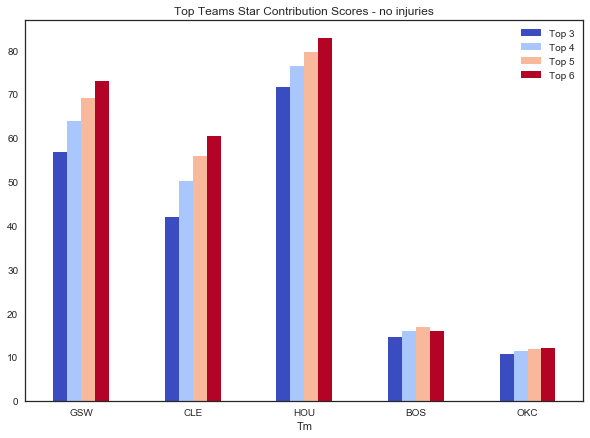

In [28]:
player_rating.loc[['GSW', 'CLE', 'HOU', 'BOS', 'OKC']].plot.bar(colormap='coolwarm')
plt.title('Top Teams Star Contribution Scores - no injuries')
plt.xticks(rotation=0)
plt.show()

In [29]:
player_rating.reset_index(level=0, inplace=True)

The Houston Rockets and Golden State are comparable in this metric. **Kevin Durant posted a stunning 30.85 player contribution score**. But if Durant is injured, that would be a huge loss to the Warriors team

In [30]:
star_contrib_3[(star_contrib_3['Tm'] == 'HOU') | (star_contrib_3['Tm'] == 'GSW')]

,Player,Tm,Weighted Contribution
64,Chris Paul,HOU,32.99
200,James Harden,HOU,23.95
65,Clint Capela,HOU,14.63
277,Kevin Durant,GSW,25.40
434,Stephen Curry,GSW,16.63
92,David West,GSW,14.84


Before every game, the injury list will be updated - the injured players will be taken away from the player contribution calculations, reflecting the negative effect of a player's absence on his team. It is a little surprsing to not see Klay Thompson in Warriors top 3, but advance statistics show that Klay has not been playing great defense recently 

## Team Strength Score

** Opponent Effect**

Team's performances are not very consistent for all teams. Regardless of the record, there are certain matchups in the NBA that teams are just struggling with. Have a look at Thunder's shooting percentage across for all teams

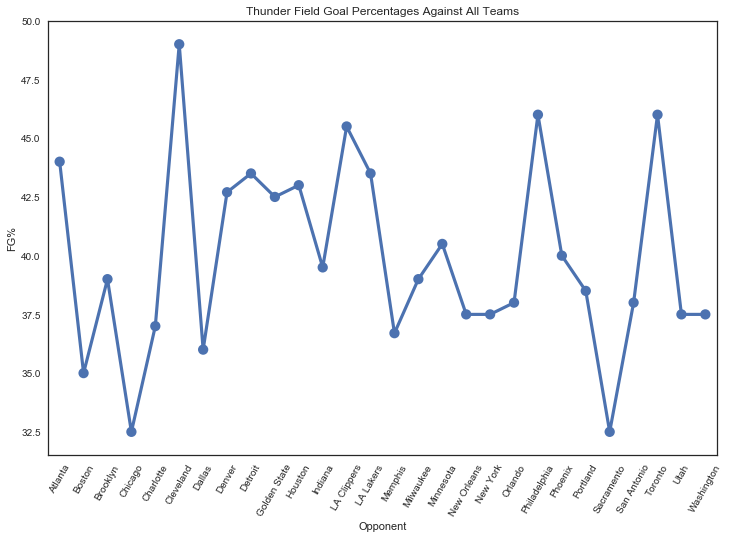

In [31]:
sns.set_context('notebook')
plt.figure(figsize=(12,8))

sns.pointplot(x = 'Value', y = 'Team FG',
              data = team_splits[team_splits['Team'] == 'OKC'][['Value', 'Team FG']])
plt.title('Thunder Field Goal Percentages Against All Teams' )
plt.xticks(rotation = 60)
plt.xlabel('Opponent')
plt.ylabel('FG%')
plt.show()

Interestingly, thunder shoots a higher percentage against good teams (Cleveland, Indiana, Toronto, Golden State) but does poorly against lottery teams (Chicago, Memphis, Sacremento)

Team's opponent effect will reflect in the statistics of Team split. Since each team only play each other maximum of 4 times, the average statistic serves as a good enough predictor of team's next game performance. These statistics will be averaged with the statistics produced with the team's hot streak

**Team's Hot Streak**

Similar to players, teams also go on hot streak. Using similar technique team's statistics could also be smoothened by EWMA model

In [32]:
smoothed_team_stats = {}
for team, games in team_gamelogs.groupby('Team'):
    smoothed_team_stats[team] = games.ewm(span = 10).mean()
    
next_game_prediction_team = {team: smoothed_team_stats[team].tail(1) for team, stats in smoothed_team_stats.items()}

next_game_prediction_team = pd.concat(next_game_prediction_team.values(), 
                                 ignore_index=True).drop(['Unnamed: 0', 'G','Home/Away', 
                                                           'Home Indicator', 'Win Indicator', 'Team ORtg', 'Team DRtg',
                                                           'Team Pace', 'Team FTr', 'Team 3PAr', 'Team TS%', 'Team TRB%',
                                                           'Team AST%', 'Team STL%', 'Team BLK%', 'Team eFG%', 'Team TOV%',
                                                           'Team ORB%', 'Team FT/FGA', 'Opponent eFG%', 'Opponent TOV%',
                                                           'Opponent DRB%'],axis=1)

next_game_prediction_team = next_game_prediction_team.fillna(0, axis=0)

**Decide on the metric that measures the team's strength**

Similar to the players contribution score, the offensive and defensive net ratings will be the metric that indicate the team's strength. The relationship could be infered by Ridge regression of Offensive/Defensive ratings onto team's raw statistics

In [33]:
X_team = team_gamelogs.as_matrix(['Team Score', 'Oponent Score', 'Team FG', 'Team FGA',
                                   'Team 3P', 'Team 3PA', 'Team FT', 'Team FTA',
                                   'Team ORB', 'Team TRB', 'Team AST', 'Team STL', 'Team BLK', 'Team TOV',
                                   'PF', 'Opponent FG', 'Opponent FGA', 'Opponent 3P',
                                   'Opponent 3PA', 'Opponent FT', 'Opponent FTA',
                                    'Opponent ORB', 'Opponent TRB', 'Opponent AST',
                                   'Opponent STL', 'Opponent BLK', 'Opponent TOV', 'Opponent PF',
                                   ])

Y_team = team_gamelogs.as_matrix(['Team ORtg', 'Team DRtg']).astype('float32')

X_train_team, X_test_team, y_train_team, y_test_team = np.asarray(train_test_split(X_team, Y_team, test_size = 0.05))

In [34]:
reg_team = Ridge(alpha=0.0001, normalize=False, max_iter=100000)
reg_team.fit(X_train_team, y_train_team)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [35]:
reg_team.score(X_test_team, y_test_team)

0.99597905477390736

Team's predicted rating on with streak metrics

Amazing fit on the team's offensive ratings over games. But that is expected

In [36]:
next_game_prediction_team['Team Streak NetRtg'] = - np.diff(reg_team.predict(next_game_prediction_team[['Team Score', 
                                                                                'Oponent Score', 'Team FG', 'Team FGA', 
                                                                               'Team 3P', 'Team 3PA', 'Team FT', 'Team FTA',
                                                                               'Team ORB', 'Team TRB', 'Team AST', 'Team STL', 
                                                                                'Team BLK', 'Team TOV', 'PF',
                                                                                'Opponent FG', 'Opponent FGA', 'Opponent 3P',
                                                                                'Opponent 3PA', 'Opponent FT', 'Opponent FTA',
                                                                               'Opponent ORB', 'Opponent TRB', 'Opponent AST',
                                                                                'Opponent STL', 'Opponent BLK', 'Opponent TOV',
                                                                                'Opponent PF'
                                                                                 ]]),   axis = 1)             

**Predict team's next game net rating**

Team's next game net ratings will be an average of team streak rating and opponent effect rating. Now use the fitted model in the last section on the team split data

In [37]:
team_splits['Team Split NetRtg'] = - np.diff(reg_team.predict(team_splits[['Team PTS', 'Opponent PTS', 'Team FG', 'Team FGA', 
                                                                          'Team 3P', 'Team 3PA', 'Team FT', 'Team FTA',
                                                                          'Team ORB', 'Team TRB', 'Team AST', 'Team STL', 
                                                                           'Team BLK', 'Team TOV', 'Team PF',
                                                                          'Opponent FG', 'Opponent FGA', 'Opponent 3P',
                                                                          'Opponent 3PA', 'Opponent FT', 'Opponent FTA',
                                                                          'Opponent ORB', 'Opponent TRB', 'Opponent AST',
                                                                          'Opponent STL', 'Opponent BLK', 'Opponent TOV',
                                                                           'Opponent PF']]), axis = 1)

In [38]:
team_opp_effect = team_splits[['Team', 'Value', 'Team Split NetRtg']].pivot(index = 'Team',  columns = 'Value', 
                                                          values = 'Team Split NetRtg').fillna(0)
team_opp_effect.reset_index(level=0, inplace=True)

Merge the team split data and team streak data to calculate the join effect of team's hot streak and their opponent effects

In [39]:
team_rating =  next_game_prediction_team[['Team', 'Team Streak NetRtg']].merge(team_opp_effect, 
                                                                               left_on = 'Team', right_on = 'Team')

## Net Player, Team, Homecourt Score 

Now aggregate all scores to get a whole view of team's predicted performance next game.

In [40]:
team_net_score = (team_rating.merge(team_homecourts, left_on = 'Team', right_on='Acronym')
                            .merge(player_rating[['Tm', 'Top 3']],
                            left_on = 'Team', right_on = 'Tm')[['Team', 'Home Strength', 'Away Strength','Top 3', 
                                                                'Team Streak NetRtg','Atlanta', 'Boston', 'Brooklyn',
                                                                'Charlotte', 'Chicago', 'Cleveland', 'Dallas', 
                                                                'Denver', 'Detroit','Golden State', 'Houston', 'Indiana',
                                                                'LA Clippers', 'LA Lakers','Memphis', 'Miami', 'Milwaukee', 
                                                                'Minnesota', 'New Orleans', 'New York',  'Oklahoma City', 
                                                                'Orlando', 'Philadelphia', 'Phoenix', 'Portland',
                                                               'Sacramento', 'San Antonio', 'Toronto', 'Utah', 'Washington']])

Normalize data

In [41]:
for i in team_net_score.columns[1:]:
    team_net_score[i] = (team_net_score[i] - min(team_net_score[i]))/(max(team_net_score[i]) - min(team_net_score[i]))

## Predict Next Game Outcome

Knowing where the game is going to be played and the featured matchups, each teams total rating could be calculated. Each team's rating will be a weighted average of the team's home/away strength, Big 3 contribution, team's streak net rating and team's opponent split rating.

In [42]:
team_net_score_home = team_net_score['Home Strength'] +  team_net_score['Top 3'] + team_net_score['Team Streak NetRtg']
team_net_score_away = team_net_score['Away Strength'] +  team_net_score['Top 3'] + team_net_score['Team Streak NetRtg']

Build team's net rating dataframe for home and away situations

In [43]:
team_net_rating_home = team_net_score.copy()[['Team','Atlanta', 'Boston', 'Brooklyn',
                                                                'Charlotte', 'Chicago', 'Cleveland', 'Dallas', 
                                                                'Denver', 'Detroit','Golden State', 'Houston', 'Indiana',
                                                                'LA Clippers', 'LA Lakers','Memphis', 'Miami', 'Milwaukee', 
                                                                'Minnesota', 'New Orleans', 'New York',  'Oklahoma City', 
                                                                'Orlando', 'Philadelphia', 'Phoenix', 'Portland',
                                                               'Sacramento', 'San Antonio', 'Toronto', 'Utah', 'Washington']]
for i in team_net_score.columns[5: ]:
    team_net_rating_home[i] += team_net_score_home

In [44]:
team_net_rating_away = team_net_score.copy()[['Team','Atlanta', 'Boston', 'Brooklyn',
                                                                'Charlotte', 'Chicago', 'Cleveland', 'Dallas', 
                                                                'Denver', 'Detroit','Golden State', 'Houston', 'Indiana',
                                                                'LA Clippers', 'LA Lakers','Memphis', 'Miami', 'Milwaukee', 
                                                                'Minnesota', 'New Orleans', 'New York',  'Oklahoma City', 
                                                                'Orlando', 'Philadelphia', 'Phoenix', 'Portland',
                                                               'Sacramento', 'San Antonio', 'Toronto', 'Utah', 'Washington']]
for i in team_net_score.columns[5:]:
    team_net_rating_away[i] += team_net_score_away

**Decide on the measuring probabilities**

The probability will be calculated by the fraction of rating each team occupy in the sum of total ratings. 

$$ P(A\ Win) = \frac{Rating\ A}{Rating\ A + Rating\ B} $$

In [45]:
def find_win_probability(home, away):
    
    home_city = teams_mapping.loc[teams_mapping['Acronym'] == home].City.to_string().split('    ')[1]
    away_city = teams_mapping.loc[teams_mapping['Acronym'] == away].City.to_string().split('    ')[1]
    
    home_rating = float(team_net_rating_home[team_net_rating_home['Team'] == home][away_city])
    away_rating = float(team_net_rating_away[team_net_rating_away['Team'] == away][home_city])
    
    P_home_win = round(home_rating/(home_rating + away_rating), 3)
    P_away_win = round(away_rating/(home_rating + away_rating), 3)
    
    d = {'Team' : pd.Series([home, away], index=['Home', 'Away']),
         'Wining Probability' : pd.Series([P_home_win, P_away_win], index=['Home', 'Away'])}
    
    return pd.DataFrame(d)

In [46]:
team_net_rating_away.to_csv('Test.csv')

Now test the results using the game schedule on Feburary 14, 2018, and see how well my model is doing

In [47]:
game_schedule[game_schedule['Date'] == '2018-02-14'][['Date', 'Home', 'Home Score', 'Away', 'Away Score']]

,Date,Home,Home Score,Away,Away Score
91,2018-02-14,Los Angeles Clippers,129.0,Boston Celtics,119.0
92,2018-02-14,Indiana Pacers,108.0,Brooklyn Nets,103.0
93,2018-02-14,Toronto Raptors,122.0,Chicago Bulls,98.0
94,2018-02-14,Atlanta Hawks,98.0,Detroit Pistons,104.0
95,2018-02-14,Sacramento Kings,91.0,Houston Rockets,100.0
96,2018-02-14,Oklahoma City Thunder,121.0,Memphis Grizzlies,114.0
97,2018-02-14,Los Angeles Lakers,117.0,New Orleans Pelicans,139.0
98,2018-02-14,Washington Wizards,118.0,New York Knicks,113.0
99,2018-02-14,Charlotte Hornets,104.0,Orlando Magic,102.0
100,2018-02-14,Miami Heat,102.0,Philadelphia 76ers,104.0


In [48]:
find_win_probability('LAC', 'BOS')

,Team,Wining Probability
Home,LAC,0.521
Away,BOS,0.479


In [49]:
find_win_probability('IND', 'BRK')

,Team,Wining Probability
Home,IND,0.667
Away,BRK,0.333


In [50]:
find_win_probability('TOR', 'CHI')

,Team,Wining Probability
Home,TOR,0.742
Away,CHI,0.258


In [51]:
find_win_probability('ATL', 'DET')

,Team,Wining Probability
Home,ATL,0.436
Away,DET,0.564


In [52]:
find_win_probability('SAC', 'HOU')

,Team,Wining Probability
Home,SAC,0.248
Away,HOU,0.752


In [53]:
find_win_probability('OKC', 'MEM')

,Team,Wining Probability
Home,OKC,0.683
Away,MEM,0.317


In [54]:
find_win_probability('LAL', 'NOP')

,Team,Wining Probability
Home,LAL,0.445
Away,NOP,0.555


In [55]:
find_win_probability('WAS', 'NYK')

,Team,Wining Probability
Home,WAS,0.733
Away,NYK,0.267


In [56]:
find_win_probability('CHO', 'ORL')

,Team,Wining Probability
Home,CHO,0.537
Away,ORL,0.463


In [57]:
find_win_probability('MIA', 'PHI')

,Team,Wining Probability
Home,MIA,0.398
Away,PHI,0.602


The only game my model mispredicted

In [58]:
find_win_probability('GSW', 'POR')

,Team,Wining Probability
Home,GSW,0.594
Away,POR,0.406


In [59]:
find_win_probability('PHO', 'UTA')

,Team,Wining Probability
Home,PHO,0.229
Away,UTA,0.771


Out of 11 games played on Feburary 14, 2018, my model successfully predicted the correct outcomes on 10 out of 11 games. The only game that the model missed is the Golden State Warriors' loss to the Portland Trail Blazers at home. As it is very rare for the defending champions to loss at home, this error is relatively acceptable.